# Imports

In [81]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

## main func

In [82]:
def main(minutes: int = 5,
         start_pos: np.array = [0.5, 0.5],
         getDF: bool = True):

    Env = Environment()
    Ag = Agent(Env)

    # agent configs
    Ag.pos = start_pos
    Ag.thigmotaxis = 0.2

    for i in range(int(minutes*60/Ag.dt)):
        Ag.update()
    explode_columns = ['pos', 'vel', 'head_direction']
    keep_columns = ['t', 'distance_travelled', 'rot_vel']

    if getDF:
        dfaux = pd.DataFrame(Ag.history)
        dfe = dfaux.explode(explode_columns, ignore_index=True)

        y_pos = [val for val in dfe[['pos']].values[1::2]]
        x_pos = [val for val in dfe[['pos']].values[0::2]]

        y_vel = [val for val in dfe[['vel']].values[1::2]]
        x_vel = [val for val in dfe[['vel']].values[0::2]]

        y_head_direction = [val for val in dfe[['head_direction']].values[1::2]]
        x_head_direction = [val for val in dfe[['head_direction']].values[0::2]]

        df = dfaux[keep_columns].copy()

        df['x_pos'] = [val[0] for val in x_pos]
        df['y_pos'] = [val[0] for val in y_pos]

        df['x_vel'] = [val[0] for val in x_vel]
        df['y_vel'] = [val[0] for val in y_vel]

        df['x_head_direction'] = [val[0] for val in x_head_direction]
        df['y_head_direction'] = [val[0] for val in y_head_direction]

        return df, Ag
    else:
        return Ag.history, Ag

In [83]:
df, ag = main(15,)
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.009917,1.790322,0.509909,0.499613,0.099090,-0.003868,0.995140,-0.098467
1,0.2,0.016702,0.250023,0.516694,0.499518,0.067847,-0.000951,0.999109,-0.042201
2,0.3,0.024784,-0.625485,0.524752,0.498900,0.080582,-0.006182,0.997881,-0.065070
3,0.4,0.032218,5.206266,0.531465,0.502094,0.067133,0.031939,0.962152,0.272514
4,0.5,0.038073,-3.595744,0.537299,0.502588,0.058339,0.004941,0.989033,0.147697


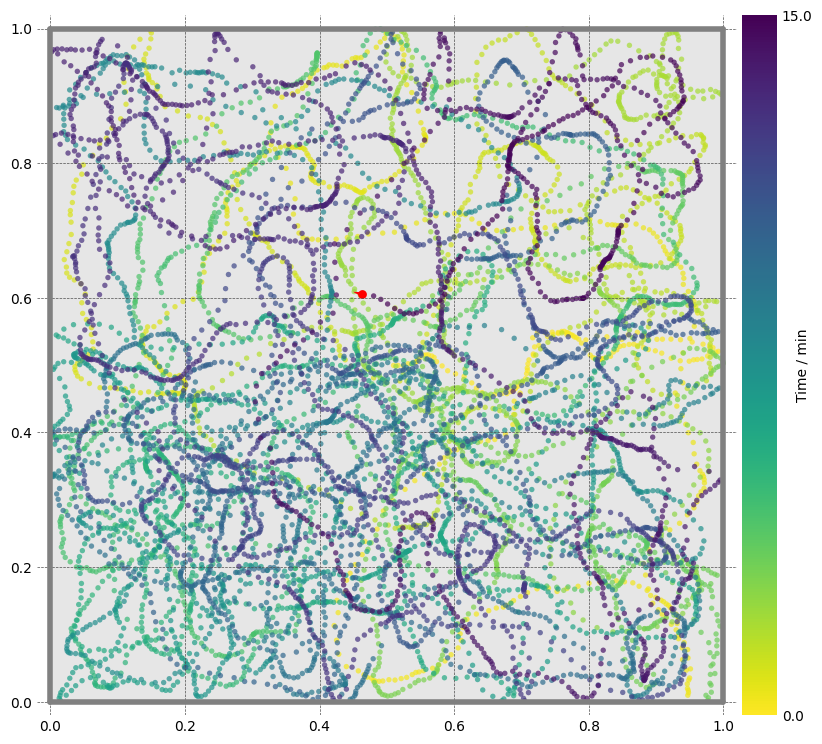

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax)
plt.show()

In [1]:
df.shape

NameError: name 'df' is not defined

# Dataset

### data array

In [85]:
feature_array = []
for x_pos,y_pos in zip(df['x_pos'], df['y_pos']):
        feature_array.append(torch.tensor([x_pos, y_pos]))

feature_array = np.array(feature_array)
feature_array = torch.tensor(feature_array)

In [86]:
feature_array[:1], feature_array.shape

(tensor([[0.5099, 0.4996]]), torch.Size([9000, 2]))

In [87]:
n = int(len(df)*0.8)
x_train = feature_array[:n]

x_test = feature_array[n:]


print(f"{x_train.shape=}", f"{x_test.shape=}")

x_train.shape=torch.Size([7200, 2]) x_test.shape=torch.Size([1800, 2])


In [88]:
x_train[0], x_train[0].shape

(tensor([0.5099, 0.4996]), torch.Size([2]))

In [89]:
x_test[0], x_test[0].shape

(tensor([0.4612, 0.2978]), torch.Size([2]))

## train configs

In [90]:
block_size = 5 # 0.5s atras  #MUDAR PRA 10 depois (1s)

x_train[:block_size+1]

tensor([[0.5099, 0.4996],
        [0.5167, 0.4995],
        [0.5248, 0.4989],
        [0.5315, 0.5021],
        [0.5373, 0.5026],
        [0.5421, 0.5040]])

## Example Loop

In [91]:
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.009917,1.790322,0.509909,0.499613,0.099090,-0.003868,0.995140,-0.098467
1,0.2,0.016702,0.250023,0.516694,0.499518,0.067847,-0.000951,0.999109,-0.042201
2,0.3,0.024784,-0.625485,0.524752,0.498900,0.080582,-0.006182,0.997881,-0.065070
3,0.4,0.032218,5.206266,0.531465,0.502094,0.067133,0.031939,0.962152,0.272514
4,0.5,0.038073,-3.595744,0.537299,0.502588,0.058339,0.004941,0.989033,0.147697


In [92]:
x_exemple = x_train[:block_size]
y_example = x_train[1:block_size+1]
for t in range(block_size):
    context = x_exemple[:t+1]
    target = y_example[t]
    print(f"when input is:", context)
    print('the target: ', target)

when input is: tensor([[0.5099, 0.4996]])
the target:  tensor([0.5167, 0.4995])
when input is: tensor([[0.5099, 0.4996],
        [0.5167, 0.4995]])
the target:  tensor([0.5248, 0.4989])
when input is: tensor([[0.5099, 0.4996],
        [0.5167, 0.4995],
        [0.5248, 0.4989]])
the target:  tensor([0.5315, 0.5021])
when input is: tensor([[0.5099, 0.4996],
        [0.5167, 0.4995],
        [0.5248, 0.4989],
        [0.5315, 0.5021]])
the target:  tensor([0.5373, 0.5026])
when input is: tensor([[0.5099, 0.4996],
        [0.5167, 0.4995],
        [0.5248, 0.4989],
        [0.5315, 0.5021],
        [0.5373, 0.5026]])
the target:  tensor([0.5421, 0.5040])


# Building Blocks

In [168]:
torch.manual_seed(1337)
batch_size = 2 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = x_train if split == 'train' else x_test
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [94]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

inputs:
torch.Size([1, 10, 2])
tensor([[[0.4480, 0.5971],
         [0.4524, 0.5820],
         [0.4505, 0.5697],
         [0.4526, 0.5573],
         [0.4531, 0.5496],
         [0.4543, 0.5448],
         [0.4555, 0.5377],
         [0.4556, 0.5299],
         [0.4561, 0.5247],
         [0.4561, 0.5218]]])
targets:
torch.Size([1, 10, 2])
tensor([[[0.4524, 0.5820],
         [0.4505, 0.5697],
         [0.4526, 0.5573],
         [0.4531, 0.5496],
         [0.4543, 0.5448],
         [0.4555, 0.5377],
         [0.4556, 0.5299],
         [0.4561, 0.5247],
         [0.4561, 0.5218],
         [0.4574, 0.5153]]])
----


In [95]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [[0.447967529296875, 0.5971459150314331]] the target: tensor([0.4524, 0.5820])
when input is [[0.447967529296875, 0.5971459150314331], [0.45240625739097595, 0.5819797515869141]] the target: tensor([0.4505, 0.5697])
when input is [[0.447967529296875, 0.5971459150314331], [0.45240625739097595, 0.5819797515869141], [0.45047977566719055, 0.5696865320205688]] the target: tensor([0.4526, 0.5573])
when input is [[0.447967529296875, 0.5971459150314331], [0.45240625739097595, 0.5819797515869141], [0.45047977566719055, 0.5696865320205688], [0.4526194930076599, 0.557251513004303]] the target: tensor([0.4531, 0.5496])
when input is [[0.447967529296875, 0.5971459150314331], [0.45240625739097595, 0.5819797515869141], [0.45047977566719055, 0.5696865320205688], [0.4526194930076599, 0.557251513004303], [0.4531072974205017, 0.5495678782463074]] the target: tensor([0.4543, 0.5448])
when input is [[0.447967529296875, 0.5971459150314331], [0.45240625739097595, 0.5819797515869141], [0.45047977

## attention mechanism

In [96]:
torch.manual_seed(1337)

F, L, C = 4, 8, 32 # # de (F)olhas,  # de (L)inhas e # de (C)olunas
head_size = 16

In [97]:
x = x_train[:F*L*C].reshape(F, L, C, 2)
print(x.shape)
x[0, 0, 0,]

torch.Size([4, 8, 32, 2])


tensor([0.5099, 0.4996])

In [98]:
two_linear = nn.Linear(2, 1, bias=False)

two_linear(x[0, 0, 0,])

tensor([-0.3072], grad_fn=<SqueezeBackward4>)

In [99]:
two_linear(x).shape, two_linear(x).reshape(F, L, C).shape

(torch.Size([4, 8, 32, 1]), torch.Size([4, 8, 32]))

In [101]:
x_ = two_linear(x).reshape(F, L, C)

###  k, q linears

In [102]:
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

In [103]:
k = key(x_)
q = query(x_)

In [104]:
k.shape, k.transpose(-2, -1).shape

(torch.Size([4, 8, 16]), torch.Size([4, 16, 8]))

In [105]:
# Vamos trocar a segunda com a terceira dimensao da matriz de keys para conseguirmos multiplicar as duas

In [106]:
wei_no_head_norm = q @ k.transpose(-2, -1) # (F, L, head_size) @ (F, head_size, L) => (F, L, L)
wei_head_norm = q @ k.transpose(-2, -1) * head_size **-0.5 # normalizando os pesos ( deixando a da multiplicacao menor que de cada matriz k e q)

wei = q @ k.transpose(-2, -1) * head_size **-0.5
wei.shape

torch.Size([4, 8, 8])

In [107]:
f"{k.var(), q.var(), wei_no_head_norm.var()}", f"{k.var(), q.var(), wei_head_norm.var()}"

('(tensor(0.0561, grad_fn=<VarBackward0>), tensor(0.0699, grad_fn=<VarBackward0>), tensor(0.0071, grad_fn=<VarBackward0>))',
 '(tensor(0.0561, grad_fn=<VarBackward0>), tensor(0.0699, grad_fn=<VarBackward0>), tensor(0.0004, grad_fn=<VarBackward0>))')

In [108]:
wei[0,:,:]

tensor([[-0.0193, -0.0268, -0.0379, -0.0316, -0.0194, -0.0209, -0.0348, -0.0370],
        [-0.0234, -0.0325, -0.0477, -0.0398, -0.0244, -0.0251, -0.0430, -0.0459],
        [-0.0389, -0.0536, -0.0703, -0.0581, -0.0359, -0.0429, -0.0672, -0.0704],
        [-0.0365, -0.0501, -0.0636, -0.0526, -0.0325, -0.0405, -0.0620, -0.0647],
        [-0.0129, -0.0180, -0.0261, -0.0216, -0.0136, -0.0140, -0.0235, -0.0251],
        [-0.0183, -0.0254, -0.0381, -0.0319, -0.0195, -0.0194, -0.0341, -0.0364],
        [-0.0384, -0.0529, -0.0707, -0.0587, -0.0360, -0.0421, -0.0671, -0.0705],
        [-0.0402, -0.0553, -0.0740, -0.0615, -0.0376, -0.0440, -0.0703, -0.0737]],
       grad_fn=<SliceBackward0>)

In [109]:
tril = torch.tril(torch.ones(L, L))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [110]:
tril.shape

torch.Size([8, 8])

In [111]:
wei_masked = wei.masked_fill(tril == 0, float('-inf'))
wei.masked_fill(tril == 0, float('-inf'))[0,:,:]

tensor([[-0.0193,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0234, -0.0325,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0389, -0.0536, -0.0703,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0365, -0.0501, -0.0636, -0.0526,    -inf,    -inf,    -inf,    -inf],
        [-0.0129, -0.0180, -0.0261, -0.0216, -0.0136,    -inf,    -inf,    -inf],
        [-0.0183, -0.0254, -0.0381, -0.0319, -0.0195, -0.0194,    -inf,    -inf],
        [-0.0384, -0.0529, -0.0707, -0.0587, -0.0360, -0.0421, -0.0671,    -inf],
        [-0.0402, -0.0553, -0.0740, -0.0615, -0.0376, -0.0440, -0.0703, -0.0737]],
       grad_fn=<SliceBackward0>)

In [112]:
nn.functional.softmax(wei, dim=1)[0,:,:]

tensor([[0.1261, 0.1266, 0.1270, 0.1266, 0.1260, 0.1263, 0.1269, 0.1270],
        [0.1256, 0.1258, 0.1257, 0.1256, 0.1254, 0.1257, 0.1259, 0.1259],
        [0.1237, 0.1232, 0.1229, 0.1233, 0.1239, 0.1235, 0.1229, 0.1228],
        [0.1240, 0.1236, 0.1237, 0.1240, 0.1244, 0.1238, 0.1235, 0.1235],
        [0.1270, 0.1277, 0.1285, 0.1279, 0.1267, 0.1271, 0.1284, 0.1285],
        [0.1263, 0.1267, 0.1269, 0.1266, 0.1260, 0.1265, 0.1270, 0.1271],
        [0.1238, 0.1233, 0.1229, 0.1232, 0.1239, 0.1236, 0.1229, 0.1228],
        [0.1235, 0.1230, 0.1224, 0.1229, 0.1237, 0.1234, 0.1225, 0.1224]],
       grad_fn=<SliceBackward0>)

In [113]:
wei_masked_softmax = nn.functional.softmax(wei_masked, dim=1)
nn.functional.softmax(wei_masked, dim=1)[0,:,:]

tensor([[0.1261, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1256, 0.1441, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1237, 0.1411, 0.1645, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1240, 0.1416, 0.1656, 0.1985, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1270, 0.1462, 0.1719, 0.2048, 0.2533, 0.0000, 0.0000, 0.0000],
        [0.1263, 0.1451, 0.1698, 0.2027, 0.2518, 0.3386, 0.0000, 0.0000],
        [0.1238, 0.1412, 0.1644, 0.1973, 0.2477, 0.3310, 0.5008, 0.0000],
        [0.1235, 0.1408, 0.1639, 0.1968, 0.2473, 0.3304, 0.4992, 1.0000]],
       grad_fn=<SliceBackward0>)

In [114]:
dropout_value = 0.5
dropout_ = nn.Dropout(dropout_value)

In [115]:
dropout_(wei_masked_softmax)[0,:,:]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2513, 0.2882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2821, 0.3289, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2831, 0.3311, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5066, 0.0000, 0.0000, 0.0000],
        [0.2525, 0.2902, 0.3397, 0.0000, 0.5036, 0.6772, 0.0000, 0.0000],
        [0.0000, 0.2823, 0.0000, 0.0000, 0.0000, 0.6620, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3277, 0.0000, 0.0000, 0.6608, 0.0000, 0.0000]],
       grad_fn=<SliceBackward0>)

In [116]:
wei_masked_softmax_drop = dropout_(wei_masked_softmax)
wei_masked_softmax_drop.shape

torch.Size([4, 8, 8])

In [117]:
v = value(x_)
v.shape

torch.Size([4, 8, 16])

In [118]:
# out
view_out = wei_masked_softmax_drop @ v
view_out.shape

torch.Size([4, 8, 16])

In [119]:
view_out[0,:,:]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0079, -0.1863, -0.0263, -0.0824, -0.0191,  0.0535, -0.0253, -0.0098,
         -0.0649,  0.1111, -0.0679,  0.0150,  0.0405,  0.0441,  0.0381,  0.0481],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0116, -0.3008, -0.0440, -0.1326, -0.0294,  0.0861, -0.0383, -0.0173,
         -0.1053,  0.1769, -0.1083,  0.0234,  0.0667,  0.0730,  0.0628,  0.0772],
        [ 0.0321, -0.2990, -0.0577, -0.1456, -0.0170,  0.0970, -0.0213, -0.0272,
         -0.1193,  0.1812, -0.1055,  0.0157,  0.0530,  0.0769,  0.0631,  0.0734],
        [ 0.0462, -0.5170, -0.1317, -0.2393, -0.0200,  0.1745,  0.0213, -0.0689,
         -0.2196,  0.3116, -0.2074,  0.0379,  0.1352,  0.1692,  0.1558,  0.1348],
        [ 0.0405, -0.8

In [120]:
out = wei_masked_softmax_drop @ v

In [121]:
C

32

In [122]:
ff_lin1 = nn.Linear(C//2, 2*C)
ff_relu = nn.ReLU()
ff_lin2 = nn.Linear(2*C, C//2)
ff_drop = nn.Dropout(dropout_value)

In [123]:
print(ff_lin1(out).shape)
out_lin1 = ff_lin1(out)
ff_lin1(out)[0,0,:]

torch.Size([4, 8, 64])


tensor([-0.1801,  0.0553, -0.0610,  0.0404, -0.1188,  0.2139,  0.0056, -0.2126,
         0.1208, -0.0746,  0.2207, -0.0422, -0.0533, -0.1881, -0.0354, -0.2360,
         0.1720,  0.0206, -0.2028,  0.1968,  0.1179,  0.1694,  0.1733,  0.2318,
        -0.1992, -0.0785, -0.0104,  0.1766,  0.0843, -0.0037,  0.2125, -0.2124,
        -0.0157, -0.1736,  0.0066, -0.0689, -0.1467, -0.2209,  0.1080, -0.1106,
        -0.2322,  0.0125,  0.1933,  0.1106,  0.0777, -0.2089, -0.1196, -0.2015,
         0.2255, -0.1632, -0.1020,  0.0665, -0.0222, -0.1960,  0.1854, -0.0833,
        -0.1890, -0.1513,  0.0144,  0.0007, -0.0638,  0.1689,  0.1967,  0.1962],
       grad_fn=<SliceBackward0>)

In [124]:
print(ff_relu(out_lin1).shape)
out_lin1_relu = ff_relu(out_lin1)
ff_relu(out_lin1)[0,0,:]

torch.Size([4, 8, 64])


tensor([0.0000, 0.0553, 0.0000, 0.0404, 0.0000, 0.2139, 0.0056, 0.0000, 0.1208,
        0.0000, 0.2207, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1720, 0.0206,
        0.0000, 0.1968, 0.1179, 0.1694, 0.1733, 0.2318, 0.0000, 0.0000, 0.0000,
        0.1766, 0.0843, 0.0000, 0.2125, 0.0000, 0.0000, 0.0000, 0.0066, 0.0000,
        0.0000, 0.0000, 0.1080, 0.0000, 0.0000, 0.0125, 0.1933, 0.1106, 0.0777,
        0.0000, 0.0000, 0.0000, 0.2255, 0.0000, 0.0000, 0.0665, 0.0000, 0.0000,
        0.1854, 0.0000, 0.0000, 0.0000, 0.0144, 0.0007, 0.0000, 0.1689, 0.1967,
        0.1962], grad_fn=<SliceBackward0>)

In [125]:
print(ff_lin2(out_lin1_relu).shape)
out_lin1_relu_lin2 = ff_lin2(out_lin1_relu)
ff_lin2(out_lin1_relu)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.0639,  0.0453,  0.0641,  0.0060,  0.0196,  0.1246, -0.0250,  0.1915,
         0.0197, -0.0874, -0.0392, -0.0280, -0.1177, -0.1133, -0.0208, -0.1193],
       grad_fn=<SliceBackward0>)

In [126]:
print(ff_drop(out_lin1_relu_lin2).shape)
out_lin1_relu_lin2_drop = ff_drop(out_lin1_relu_lin2)
ff_drop(out_lin1_relu_lin2)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.1277,  0.0000,  0.1283,  0.0120,  0.0393,  0.0000, -0.0000,  0.3829,
         0.0000, -0.0000, -0.0000, -0.0560, -0.0000, -0.0000, -0.0415, -0.2386],
       grad_fn=<SliceBackward0>)

In [127]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [128]:
feedforward = FeedFoward(C)

In [129]:
print(feedforward(out).shape)
feedforward(out)[0,0,:]

torch.Size([4, 8, 16])


tensor([-0.0000,  0.1239,  0.0000, -0.0316,  0.0000,  0.1456, -0.2149, -0.0028,
         0.1022,  0.0000,  0.0000, -0.1006,  0.1985, -0.0958,  0.0000,  0.2131],
       grad_fn=<SliceBackward0>)

In [130]:
# full copied
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# torch.manual_seed(1337)
# module = LayerNorm1d(100)
# x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
# x = module(x)
# x.shape

In [131]:
lay_norm = LayerNorm1d(C//2)

In [132]:
print(lay_norm(out).shape)
lay_norm(out)[0,0,:]

torch.Size([4, 8, 16])


tensor([-1.1184,  1.1295,  1.0851,  1.1386,  1.0481, -1.1342,  0.6816,  1.0303,
         1.1354, -1.1372,  1.1216, -1.0546, -1.0844, -1.0996, -1.0806, -1.1259],
       grad_fn=<SliceBackward0>)

### head class

In [134]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

### block class

In [150]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = Head(n_head, head_size, block_size, dropout)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

#### test block class

In [147]:
model = Block(100, 1, 10, 0.0)

In [169]:
xb, yb = get_batch('train')

In [170]:
xb.shape

torch.Size([2, 10, 2])

In [171]:
xb

tensor([[[0.4480, 0.5971],
         [0.4524, 0.5820],
         [0.4505, 0.5697],
         [0.4526, 0.5573],
         [0.4531, 0.5496],
         [0.4543, 0.5448],
         [0.4555, 0.5377],
         [0.4556, 0.5299],
         [0.4561, 0.5247],
         [0.4561, 0.5218]],

        [[0.1899, 0.4576],
         [0.1876, 0.4582],
         [0.1838, 0.4596],
         [0.1806, 0.4594],
         [0.1740, 0.4578],
         [0.1670, 0.4576],
         [0.1640, 0.4572],
         [0.1582, 0.4565],
         [0.1461, 0.4603],
         [0.1340, 0.4590]]])

In [172]:
two_linear(xb)

tensor([[[-0.2708],
         [-0.2734],
         [-0.2722],
         [-0.2734],
         [-0.2736],
         [-0.2743],
         [-0.2750],
         [-0.2750],
         [-0.2752],
         [-0.2752]],

        [[-0.1161],
         [-0.1147],
         [-0.1124],
         [-0.1105],
         [-0.1066],
         [-0.1024],
         [-0.1006],
         [-0.0972],
         [-0.0900],
         [-0.0827]]], grad_fn=<UnsafeViewBackward0>)

In [167]:
two_linear(xb).squeeze(0).squeeze(1).shapes
#.reshape(1, F, L, C)

torch.Size([10])

In [143]:
xb.shape

torch.Size([1, 10, 2])

In [ ]:
        #self.four_linear = nn.Linear(4, 1, bias=False) # going from x_hd, y_hd, x_vl, y_vl to one number